torch.Size([100, 1, 28, 28])


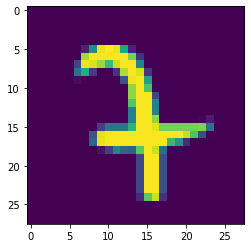

In [41]:
import torch
import torchvision
from torchvision import transforms, datasets
import time
train = datasets.MNIST('', train=True, download=True, 
                       transform=transforms.Compose([
                                transforms.ToTensor()
                            ]))
test = datasets.MNIST('', train=False, download=True, 
                       transform=transforms.Compose([
                                transforms.ToTensor()
                            ]))

trainset = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, pin_memory=True)
testset = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, pin_memory=True)
                                      
# show an image for example
import matplotlib.pyplot as plt
X, y = iter(trainset).next()
print(X.shape) # the batch is 10 example. And each example is 28 * 28 pixels
plt.imshow(X[0].view(28, 28)) # the image size is 28 by 28

In [42]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [43]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(28 * 28, 64)  # the image size is 28 by 28
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x, dim=1)

In [44]:
start_time = time.time()

net = Net() # inital network 
optimizer = optim.Adam(net.parameters(), lr=0.001)  # create a Adam optimizer

net.train()
epochs = 2
for epoch in range(epochs):
    for data in trainset:
        X, y = data
        # training process
        optimizer.zero_grad()    # clear the gradient calculated previously
        predicted = net(X.view(-1, 28 * 28))  # put the mini-batch training data to Nerual Network, and get the predicted labels
        loss = F.nll_loss(predicted, y)  # compare the predicted labels with ground-truth labels
        loss.backward()      # compute the gradient
        optimizer.step()     # optimize the network
    print(loss)
    
print("CPU Spent Time: %f" % (time.time() - start_time))    

tensor(0.1997, grad_fn=<NllLossBackward>)
tensor(0.2047, grad_fn=<NllLossBackward>)
CPU Spent Time: 19.554386


In [45]:
# Evaluation the training data
start_time = time.time()
"""
model.train()" and "model.eval()" activates and deactivates Dropout and BatchNorm, so it is quite important. 
"with torch.no_grad()" only deactivates gradient calculations, but doesn't turn off Dropout and BatchNorm.
Your model accuracy will therefore be lower if you don't use model.eval() when evaluating the model.
"""
net.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in trainset:
        X, y = data
        output = net(X.view(-1, 28 * 28))
        correct += (torch.argmax(output, dim=1) == y).sum().item()
        total += y.size(0)

print(f'Training data Accuracy: {correct}/{total} = {round(correct/total, 3)}')

# Evaluation the testing data
correct = 0
total = 0
with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1, 28 * 28))
        correct += (torch.argmax(output, dim=1) == y).sum().item()
        total += y.size(0)

print(f'testing data Accuracy: {correct}/{total} = {round(correct/total, 3)}')

print("CPU Spent Time: %f" % (time.time() - start_time))     


Training data Accuracy: 57105/60000 = 0.952
testing data Accuracy: 9503/10000 = 0.95
CPU Spent Time: 8.806992


In [46]:
# The GPU version
torch.cuda.init()
start_time = time.time()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = Net() # inital network 
net.to(device) #these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:
optimizer = optim.Adam(net.parameters(), lr=0.001)  # create a Adam optimizer

net.train()
epochs = 2

for epoch in range(epochs):
    for data in trainset:
        X, y = data
        X, y = X.to(device), y.to(device)   # Remember that you will have to send the inputs and targets at every step to the GPU too
        # training process
        optimizer.zero_grad()    # clear the gradient calculated previously
        predicted = net(X.view(-1, 28 * 28))  # put the mini-batch training data to Nerual Network, and get the predicted labels
        loss = F.nll_loss(predicted, y)  # compare the predicted labels with ground-truth labels
        loss.backward()      # compute the gradient
        optimizer.step()     # optimize the network
    print(loss)
    
print("GPU Spent Time: %f" % (time.time() - start_time))    

cuda:0
tensor(0.2444, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0567, device='cuda:0', grad_fn=<NllLossBackward>)
GPU Spent Time: 19.941451


In [47]:
# Evaluation the training data
start_time = time.time()

net.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in trainset:
        X, y = data
        X, y = X.to(device), y.to(device)   # Remember that you will have to send the inputs and targets at every step to the GPU too
        output = net(X.view(-1, 28 * 28))
        correct += (torch.argmax(output, dim=1) == y).sum().item()
        total += y.size(0)

print(f'Training data Accuracy: {correct}/{total} = {round(correct/total, 3)}')

# Evaluation the testing data
correct = 0
total = 0
with torch.no_grad():
    for data in testset:
        X, y = data
        X, y = X.to(device), y.to(device)   # Remember that you will have to send the inputs and targets at every step to the GPU too
        output = net(X.view(-1, 28 * 28))
        correct += (torch.argmax(output, dim=1) == y).sum().item()
        total += y.size(0)

print(f'testing data Accuracy: {correct}/{total} = {round(correct/total, 3)}')

print("GPU Spent Time: %f" % (time.time() - start_time))    

# Note:
# In this projects the GPU is not much faster than CPU, the one reason is that this nerual network is very small, 
# and the batch size also effect the speed. 

Training data Accuracy: 57221/60000 = 0.954
testing data Accuracy: 9486/10000 = 0.949
GPU Spent Time: 8.062385
